<a href="https://colab.research.google.com/github/arkB/DLFS2/blob/master/DLFS2_ch03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1jJNYTm2oOyHuqn_4usJ4BMuaCE4BAVav/" config

!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
import os
os.chdir('drive')

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110845 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

# 3. word2vec

2章では「**カウントベースの手法（コーパス中の各単語に対して、その単語の周囲の頻度をカウントし集計する手法）**」を学びました。

3章では「カウントベースの手法」の問題点を示し、それに代わる「推論ベースの手法」を紹介します。

「推論ベースの手法」とは、下の図のように周囲の単語（コンテクスト）が与えられたときに「？」に当てはまる単語を推測し答えを与えるための手法のことです。

<img width="655.5" alt="キャプチャ.PNG (21.5 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/9782ee68-f48c-42f4-b63d-0a170840ad5e.PNG">

具体的には、「推論ベースの手法」では、モデルを学習させてそのモデルにコンテキストを与えると「？」に当てはまる単語の出現確率を出力します。

今回ここではモデルとして「ニューラルネットワーク」を用います。

ちなみに、「推論ベースの手法」も「カウントベースの手法」もどちらも「分布仮説（単語の意味は周囲の単語によって形成される）」に基づいています。

<img width="656.25" alt="キャプチャ.PNG (28.8 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/9a178ff1-bf35-4b74-8353-d6b1932513e4.PNG">

## 3.1.1 カウントベース手法の問題点

「カウントベースの手法」の問題点としては、コーパス全体の語彙数が膨大（英語の語彙数は100万）になると、その語彙数×語彙数の行列を作る必要があり、$n \times n$ 行列に $O(n^3)$ の計算量の SVD は、計算量の点で現実的ではありません。

例えば、[LAPACK のベンチマーク](http://www.netlib.org/lapack/lug/node71.html) の SVD の計算時間をみると $ n = 100, 1000 $ のケースで下の表のような結果となります（表の古い計算機で $10 \sim 100$ secオーダーの時間がかかる）。

<img width="534" alt="キャプチャ.PNG (37.9 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/2b3ac64b-ce4b-415f-a754-81478c922281.PNG">

$n$ の増加に伴い $O(n^3)$ の計算量は下図のように増加していきます（$n=100$ 万の計算量は現実的ではない）。

![68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3231353939332f37623966643861302d633765382d343566342d306137622d6633383233356562663838332e6a706567.jpg (149.6 kB)](https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/d05b0ad0-a089-41f8-a77a-9a3254276d2a.jpg)


一方、「推論ベースの手法」のモデルの学習で「ニューラルネットワーク」を用いる場合、ミニバッチという形でコーパスの一部を切り取って学習し、その結果から重みを更新していくため、現実的な計算量に制限した計算をGPU等で並列分散処理させつつ繰り返し実施することで、学習モデルの精度を向上させていくことが可能です（下図）。

<img width="651.75" alt="キャプチャ.PNG (25.7 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/f55ea538-6f24-4910-bcd8-1935ced88601.PNG">

## 3.1.3 ニューラルネットワークにおける単語の処理方法

「ニューラルネットワーク」を用いて単語を処理するにあたりそのまま "you", "say" のような単語をそのまま処理することはできません。

そのため「one-hot 表現 or one-hot ベクトル（ベクトルの要素の1つが1で残りが0となるようなベクトル）」を用います。

ここでは「you say goodbye and i say hello.」という一文をコーパスとして用います。

このコーパスには7個の語彙（"you", "say", "goodbye", "and", "i", "hello", ".") があります。

例えば "you", "goodbye" の one-hot 表現の例としては下記です。

<img width="650.25" alt="キャプチャ.PNG (22.4 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/874f0b10-184d-4590-a1ac-65467eb183ce.PNG">

単語をベクトル表現できれば、そのベクトルはニューラルネットワークの「レイヤ」によって処理することができます。

ニューラルネットワークの入力層は下記です。

<img width="650.25" alt="キャプチャ.PNG (55.9 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/fcf412a8-4867-4954-a6b7-6ec357644326.PNG">

全結合層で入力層を変換する場合、例えば下図のように表わせます（ここでは中間層を3つのニューロンとする）。

<img width="652.5" alt="キャプチャ.PNG (51.9 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/583676a6-306e-4f5f-8d77-9f7e120257d8.PNG">

ちなみに非全結合と全結合は下図で、例えば畳み込みニューラルネットワーク（CNN）では非全結合が用いられます。

<img width="462.75" alt="キャプチャ.PNG (55.6 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/44f56668-fdd0-4292-8d1c-a3db3387cfe1.PNG">

全結合による変換を数式で表すと、入力層のベクトル $c \in \mathbb R^{D}$ に対して、行列 $W \in \mathbb R^{d\times D}$ とバイアスベクトル $b \in \mathbb R^{d}$ を用いて

$$
h = Wc +b
$$

と表せます。ここでは word2vec の説明を見越して、バイアスは省略し、$b = 0$ とします。

すると全結合の変換は単なる行列の積 $h = Wc$ として表せるので、Python としては例えば次のように表現できます。

In [0]:
import numpy as np
c = np.array([[1,0,0,0,0,0,0]]) #入力
W = np.random.randn(7,3) #重み
h = np.dot(c, W) #中間層ベクトル
print(h)

[[-1.93192108  0.16090549 -0.10415464]]


1章で実装した MatMal レイヤを用いると下記のようなコードになります。

In [0]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.23442125 -1.27825193  0.68147704]]


上記計算の注目点としては、$c$ は one-hot 表現のため $Wc$ という行列の積は実質的には、one-hot 表現で 1 が入っている列の番号と同じ番号の W の行を抜き出すことと同じという点です（下図）。

<img width="652.5" alt="キャプチャ.PNG (47.7 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/08/31597/2634bf25-fde0-4c44-a59e-81e843e9166f.PNG">

# 3.2 word2vec の CBOW(continuous bag-of-words) モデル

ここでは「推論ベースの手法」のモデルに「ニューラルネットワーク」を組み込みます。

その「ニューラルネットワーク」のモデルとしては word2vec の モデルとしては大きく2つ continuous bag-of-words モデル（以降CBOW）および skip-gram モデル があります。

違いとしては下図のように CBOW モデルではコンテクストが複数あり、その複数のコンテクストから中央の単語（「ターゲット」）を推測します。

一方 skip-gram モデルでは中央の単語（「ターゲット」）から周囲の複数ある単語（「コンテクスト」）を推測します。

<img width="652.5" alt="キャプチャ.PNG (23.4 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/09/31597/2eda6be8-ecfc-435e-8480-e0e9a176cc0b.PNG">

ここではまずは CBOW モデルの推論および学習について説明をします。

## 3.2.1 CBOW モデルの推論処理

CBOW モデルのネットワークは下図です。

コンテクスト $ \bf{h}_1, \bf{h}_2$ を入力層として、入力層から中間層への変換は重み $ \bf{W}_i$ を用い、中間層から出力層への変換は重み $ \bf{W}_o $ を用います。

中間層は $\frac{1}{2} (\bf{h}_1 + \bf{h}_2)$ にて求めます。

<img width="650.25" alt="キャプチャ.PNG (73.2 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/09/31597/adf60223-dbb7-4221-a218-d9580723be43.PNG">

CBOW モデルの推論処理を Python で記述したのが下記です。



In [0]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# サンプルのコンテクストデータ
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 重みの初期化
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[ 0.0936329  -0.40608182 -0.169034    0.16569896 -0.01936698 -0.06109344
  -0.18014601]]


## 3.2.2 CBOW モデルの学習

学習時の CBOW モデルのネットワーク構成は下図です。

<img width="654" alt="キャプチャ.PNG (33.9 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/09/31597/5d038fde-3aca-4dac-870d-7bac451bd8b2.PNG">

Softmax 関数とは、各ラベルのスコア $s_k$ を用いて下記のように表せます。

Softmax 関数を通すと 各ラベルの出力 $y_k$ は 0.0 以上 1.0 以下の値（$k$ 番目のラベルが出現する確率）として出力されます。

$$y_k = \frac{\exp(s_k)}{\sum_i \exp(s_i)}$$

交差エントロピー誤差は正解ラベルの one-hot表現されたベクトルの成分 $t_k$ およびSoftmax関数の出力 $y_k$ を用いて以下のように表されます。

$$L = -\sum_k t_k \log y_k$$

CBOW モデルのコンテクストからのターゲットの推測（下図）を確率的に表現すると

<img width="653.25" alt="キャプチャ.PNG (20.0 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/09/31597/28153b56-b006-481f-8991-bf958d196035.PNG">

$$P(w_t | w_{t-1}, w_{t+1}) $$

となります。

こちらは「コンテクストとして $w_{t-1}, w_{t+1}$ が与えられた場合にターゲット が $w_t$ となる確率」です。


この確率は上記 $y_k$ に対応するもので、交差エントロピー誤差は、one-hot表現では $w_t$ が起こる事象で 1 , それ以外で 0 になることを考慮すると以下になります。

$$L = -\log P(w_t | w_{t-1}, w_{t+1})$$

これをコーパス全体に拡張すると次のような交差エントロピー誤差の和として表されます。

$$L = -\frac{1}{T} \sum_t^T \log P(w_t | w_{t-1}, w_{t+1})$$

word2vec（CBOW, skip-gram）の学習では、入力側の重み $\bf{W}_i$ を上記の交差エントロピー誤差の和 $L$ を最小にするように最適化していきます（一般的には出力側の重み $\bf{W}_o$ はあまり用いられないとのこと）。

学習ネットワークの構成のポイント：

<img width="654.75" alt="キャプチャ.PNG (77.5 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/09/31597/ad051386-8ec4-46c7-857a-ac4fc22e2d80.PNG">

# 3.3 学習データの準備

## 3.3.1 コンテクストとターゲットおよびそれらの one-hot表現

word2vec （CBOW）のニューラルネットワークへの入力は「コンテクスト」です。正解のラベルとしてはコンテクストに囲まれた中央の単語である「ターゲット」です。

ニューラルネットワークの学習としては、「コンテクスト」を入力したときに「ターゲット」が出力される

"You say goodbye and I say hello." という「コーパス」から「コンテクスト」と「ターゲット」をリスト化したケースが下図です。

<img width="651.75" alt="キャプチャ.PNG (46.5 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/09/31597/76b96308-0525-435a-8b49-40b2bceba210.PNG">

さらにコンテクストとターゲットを one-hot 表現にする処理の流れを表したのが下図です。

<img width="655.5" alt="キャプチャ.PNG (49.0 kB)" src="https://img.esa.io/uploads/production/attachments/8793/2019/01/09/31597/08a0ff33-4a6e-44eb-9392-92d7af70f568.PNG">

具体的に Python コードの実装としては下記になります。

In [0]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [0]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [0]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)

contexts = convert_one_hot(contexts, vocab_size)

print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW モデルの実装

CBOW モデルの学習コードおよびその実行結果は下記になります。

ここでは、ウインドウサイズ 1, 中間層のノードが5つ、バッチサイズ 3, 学習回数1000 としています。

学習回数を重ねるごとに損失が減少していることが確認できます。

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

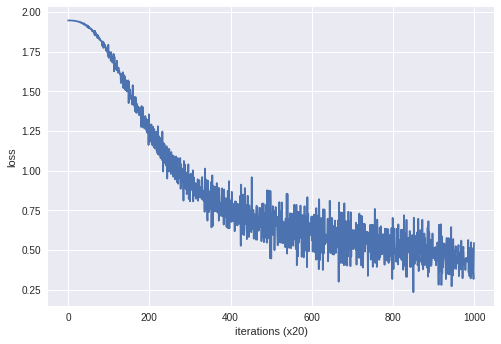

In [0]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

入力層の重み$\bf{W}_i$ は word_vecs というメンバ変数に格納されています。

word_vecs の各行に対応する単語ID の分散表現が格納されています。

In [0]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-1.0774181  -0.41502443 -1.3285251   1.3598249   1.2219367 ]
say [ 1.2927059  -1.2872394   0.41435072 -0.01135265 -0.44694942]
goodbye [-0.8319485   1.4571052  -0.62633795  0.5318103   0.67397696]
and [ 1.129695  -1.1180661  1.3881688  1.4450581  1.6253179]
i [-0.79824674  1.4709252  -0.61878735  0.50901085  0.6567813 ]
hello [-1.0821677  -0.40568072 -1.347526    1.3584945   1.2378774 ]
. [ 1.0816252 -1.0866023 -1.4564561 -1.2368044 -1.2329001]


本来であればこちらの分散表現が「単語の意味」を上手く捉えたベクトル表現となっていることが期待されますが、残念ながら今回扱ったコーパスのサイズが小さいため、良い結果は得られてないです。

もちろん、コーパスサイズを大きくすれば良い結果が期待されますが、今回実装した CBOW モデルでは処理速度の点で問題があります。

次章以降で処理速度の問題を解決する「本物」の CBOW モデルの実装をおこなっていきます。

## （応用）夏目漱石の「こころ」を word2vec で学習される方法

アドバンスな題材として、コーパスサイズを大きくした場合を検討してみます。

ここでは、青空文庫にある夏目漱石の「こころ」を word2vec で学習させて、「先生」という単語に関連の深い単語を列挙してみましょう（[参考](https://qiita.com/makaishi2/items/63b7986f6da93dc55edd)）

具体的なコードおよび実行結果としては下記です。

In [0]:
# 夏目漱石「こころ」のファイルダウンロード、解凍
!wget https://www.aozora.gr.jp/cards/000148/files/773_ruby_5968.zip
!unzip 773_ruby_5968.zip
!ls -l kokoro.txt

--2019-01-09 03:04:13--  https://www.aozora.gr.jp/cards/000148/files/773_ruby_5968.zip
Resolving www.aozora.gr.jp (www.aozora.gr.jp)... 59.106.13.115
Connecting to www.aozora.gr.jp (www.aozora.gr.jp)|59.106.13.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153688 (150K) [application/zip]
Saving to: ‘773_ruby_5968.zip’

773_ruby_5968.zip   100%[===================>] 150.09K  --.-KB/s    in 0.01s   

2019-01-09 03:04:18 (12.1 MB/s) - ‘773_ruby_5968.zip’ saved [153688/153688]

Archive:  773_ruby_5968.zip
Made with MacWinZipper™
  inflating: kokoro.txt              
-rw-r--r-- 1 root root 374152 Oct 31  2010 kokoro.txt


In [0]:
import codecs
# ファイル読込み、内部表現化
f = codecs.open('kokoro.txt', "r", "sjis")
text = f.read()
f.close()

# ファイル整形
import re
# ヘッダ部分の除去
text = re.split('\-{5,}',text)[2]
# フッタ部分の除去
text = re.split('底本：',text)[0]
# | の除去
text = text.replace('|', '')
# ルビの削除
text = re.sub('《.+?》', '', text)
# 入力注の削除
text = re.sub('［＃.+?］', '',text)
# 空行の削除
text = re.sub('\n\n', '\n', text) 
text = re.sub('\r', '', text)

# 整形結果確認

# 頭の100文字の表示 
print(text[:100])
# 見やすくするため、空行 
print()
print()
# 後ろの100文字の表示 
print(text[-100:])



上　先生と私


一

　私はその人を常に先生と呼んでいた。だからここでもただ先生と書くだけで本名は打ち明けない。これは世間を憚かる遠慮というよりも、その方が私にとって自然だからである。私はその人


、なるべく純白に保存しておいてやりたいのが私の唯一の希望なのですから、私が死んだ後でも、妻が生きている以上は、あなた限りに打ち明けられた私の秘密として、すべてを腹の中にしまっておいて下さい。」






In [0]:
# Janomeのインストール
!pip install janome

# Janomeのロード
from janome.tokenizer import Tokenizer

# Tokenneizerインスタンスの生成 
t = Tokenizer()

# テキストを引数として、形態素解析の結果、名詞・動詞原型のみを配列で抽出する関数を定義 
def extract_words(text):
    tokens = t.tokenize(text)
    return [token.base_form for token in tokens 
        if token.part_of_speech.split(',')[0] in['名詞', '動詞']]

#  関数テスト
ret = extract_words('精神的に向上心がないものは馬鹿だといって、何だか私をさも軽薄もののようにやり込めるのです。')
for word in ret:
    print(word)

# 全体のテキストを句点('。')で区切った配列にする。 
sentences = text.split('。')
# それぞれの文章を単語リストに変換(処理に数分かかります)
word_list = [extract_words(sentence) for sentence in sentences]

# 結果の一部を確認 
for word in word_list[0]:
    print(word)

精神
的
向上心
もの
馬鹿
いう
私
薄もの
よう
やり込める
の
上
先生
私
一
私
人
先生
呼ぶ
いる


In [0]:
# Word2Vecライブラリの導入
!pip install gensim  

# Word2Vecライブラリのロード
from gensim.models import word2vec

# size: 圧縮次元数
# min_count: 出現頻度の低いものをカットする
# window: 前後の単語を拾う際の窓の広さを決める
# iter: 機械学習の繰り返し回数(デフォルト:5)十分学習できていないときにこの値を調整する
# model.wv.most_similarの結果が1に近いものばかりで、model.dict['wv']のベクトル値が小さい値ばかりの 
# ときは、学習回数が少ないと考えられます。
# その場合、iterの値を大きくして、再度学習を行います。

# 事前準備したword_listを使ってWord2Vecの学習実施
model = word2vec.Word2Vec(word_list, size=50,min_count=5,window=5,iter=1000)

In [0]:
# 結果の確認1
# 一つ一つの単語は100次元のベクトルになっています。 
# 「先生」のベクトル値を確認します。
print(model.__dict__['wv']['先生'])

[ 0.6569985  -0.11994954 -0.6427742   1.213398   -1.8398448   1.1827036
  0.4986367   0.04548284  2.44457     1.4014504  -0.9706929  -0.66404366
 -1.4268262   0.06282885  1.6198504  -1.1201216  -0.17802139  0.29679334
 -0.27737296  0.4717287  -0.7174956  -2.2708552  -0.28564936 -1.7458433
 -0.10778152 -0.30328184  0.48663938  1.4171972  -0.8220578   0.22087117
  0.7119671   1.7111647  -0.5076243   0.821836   -0.42733327  1.0684468
 -0.8721215  -0.70046467 -1.2951814   0.60690194  0.46786955  0.3648031
 -1.6260331   1.2887772  -0.27446723 -1.2381439   0.31714582  0.08626555
 -0.5637      0.30560726]


In [0]:
# 結果の確認2
# 関数most_similarを使って「先生」の類似単語を調べます 
ret = model.wv.most_similar(positive=['先生']) 
for item in ret:
    print(item[0], item[1])

奥さん 0.523717999458313
私 0.5059327483177185
あなた 0.43613502383232117
時 0.3846054673194885
する 0.36490634083747864
食卓 0.35665929317474365
財産 0.34628137946128845
式 0.3399178683757782
いう 0.3294997811317444
出す 0.32745128870010376


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## 3.5.3 カウントベース vs 推論ベース

本章の最初に学習される計算量の面で推論ベースの手法のメリットを挙げました。

それではカウントベースと推論ベースの2つの手法の分散表現の性質や精度についてはどうでしょうか？

分散表現の性質という点では、カウントベースの手法では単語どうしの類似性をエンコードすることができますが、類推ベースの手法では単語どうしの類似性のみならず単語間のパターンも捉えられる（「king - man + woman = queen」のような類推問題が解ける）ことが分かっています。

精度という点では、類推ベースの手法がカウントベースの手法に比べて精度が優れているという誤解もありますが、実際は2つの手法には優劣がつけられないことがいくつかの論文で報告されています。

* "[Improving distributional similarity with lessons learned from word embeddings.](http://www.aclweb.org/anthology/Q15-1016)"

* "[Neural word embedding as implicit matrix factorization.](https://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf)"

